<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/CNN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/data/tfData/'
ds = tf.data.Dataset.load(path)

In [3]:
ds.element_spec

(TensorSpec(shape=(16, 256, 256, 10), dtype=tf.float64, name=None),
 TensorSpec(shape=(16, 256, 256), dtype=tf.float64, name=None))

In [43]:
# Determine the size of the full dataset
DATASET_SIZE = tf.data.experimental.cardinality(ds).numpy()

# Determine the sizes of the training and validation sets
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = int(0.2 * DATASET_SIZE)

# Shuffle the data
full_dataset = ds.shuffle(DATASET_SIZE)

# Split into train and validation datasets
train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print('Number of train samples: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation samples: %d' % tf.data.experimental.cardinality(val_dataset).numpy())

Number of train samples: 16
Number of validation samples: 4


In [15]:
def train_model(model, datasets, epochs = 10, steps_per_epoch = 2, validation_steps = 1, early_stopping = True, learning_rate = False):

  callbacks = []
  if early_stopping:
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 1e-4 , patience = 10, restore_best_weights= True))

  history = model.fit(datasets[0], epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=datasets[1], validation_steps=validation_steps, callbacks = callbacks)
  return(history)

In [32]:
import matplotlib.pyplot as plt


# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(8, 8))
  plt.suptitle('Training Curves')
  # plot loss
  plt.subplot(311)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(312)
  plt.title('root_mean_squared_error')
  plt.plot(history.history['root_mean_squared_error'], color='blue', label='train')
  plt.plot(history.history['val_root_mean_squared_error'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(313)
  plt.title('MAE')
  plt.plot(history.history['mean_absolute_error'], color='blue', label='train')
  plt.plot(history.history['val_mean_absolute_error'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

# print test set evaluation metrics
def model_evaluation(model, evaluation_steps, test_set):
  print('\nTest set evaluation metrics')
  loss0,rmse,mae = model.evaluate(test_set, steps = evaluation_steps)
  print("loss: {:.2f}".format(loss0))
  print("rmse: {:.2f}".format(rmse))
  print("mae: {:.2f}".format(mae))

def model_report(model, history, test_set, evaluation_steps = 10):
  plt = summarize_diagnostics(history)
  plt.show()
  model_evaluation(model, evaluation_steps, test_set)

In [12]:
## first cnn architecture
## change of kernel size might bring better results from 3,3 to 5,5 or 6,6

from tensorflow.keras import models, layers


def init_tenet32(summary):
  model = models.Sequential(name="TeNeT_32")
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256,256,10)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(1, (3, 3), activation='relu', padding='same'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001), loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
  if summary:
    model.summary()
  return model

In [44]:
%%time
TeNeT_32 = init_tenet32(summary = True)
TeNeT_32_history = train_model(TeNeT_32, (train_dataset, val_dataset), 10, None, None, early_stopping=False, learning_rate=False)

Model: "TeNeT_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 32)      2912      
                                                                 
 conv2d_25 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 256, 256, 1)       1153      
                                                                 
Total params: 96,417
Trainable params: 96,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 400s 24s/step - loss: 0.0923 - root_mean_squared_error: 0.3038 - mean_absolute_error: 0.0241 - val_loss: 0.1695 - val_root_mean_square

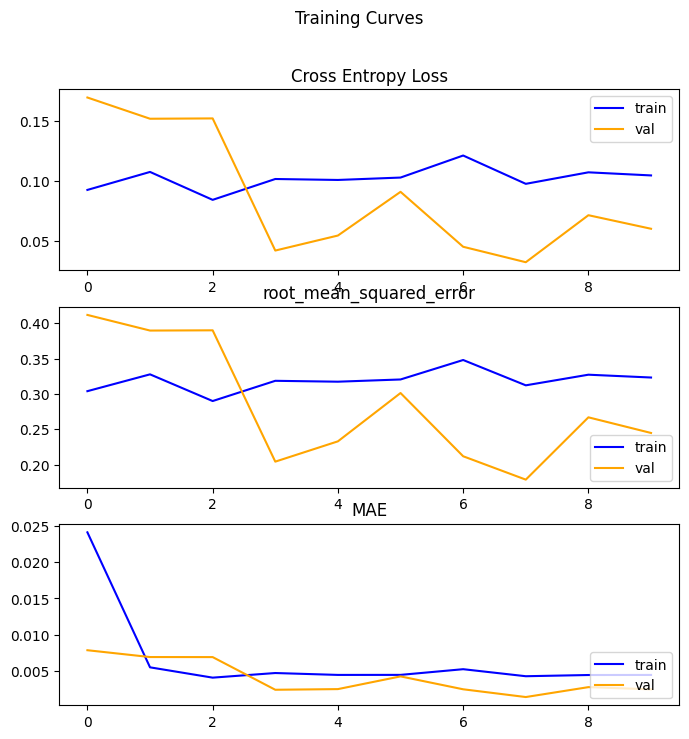


Test set evaluation metrics
 4/10 [===========>..................] - ETA: 27s - loss: 0.0436 - root_mean_squared_error: 0.2089 - mean_absolute_error: 0.0020

10/10 [==============================] - 29s 2s/step - loss: 0.0436 - root_mean_squared_error: 0.2089 - mean_absolute_error: 0.0020
loss: 0.04
rmse: 0.21
mae: 0.00


In [45]:
model_report(TeNeT_32,TeNeT_32_history, val_dataset)

In [40]:
## second architecture
## had some problems running it, session was getting shut

def init_unet():
    inputs = tf.keras.Input(shape=(256, 256, 10))

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Middle
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)

    # Decoder
    up1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2)
    merge1 = layers.concatenate([up1, conv1])
    conv3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge1)

    # Output
    output = layers.Conv2D(1, (1, 1))(conv3)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

unet = init_unet()
unet.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [41]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  2912        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 32  0          ['conv2d_20[0][0]']              
                                )                                                           

In [42]:
%%time
unet_history = train_model(unet, (train_dataset, val_dataset), 10, None, None, early_stopping=False, learning_rate=False)

Epoch 1/10
2/2 [==============================] - 34s 17s/step - loss: 0.0495 - val_loss: 0.1058
Epoch 2/10
2/2 [==============================] - 42s 33s/step - loss: 0.1501 - val_loss: 0.0173
Epoch 3/10
2/2 [==============================] - 29s 21s/step - loss: 0.0206 - val_loss: 0.0955
Epoch 4/10
2/2 [==============================] - 26s 19s/step - loss: 0.2662 - val_loss: 0.4777
Epoch 5/10
2/2 [==============================] - 26s 19s/step - loss: 0.0596 - val_loss: 0.0210
Epoch 6/10
2/2 [==============================] - 24s 17s/step - loss: 0.0382 - val_loss: 0.0871
Epoch 7/10
2/2 [==============================] - 25s 16s/step - loss: 0.0173 - val_loss: 0.4678
Epoch 8/10
2/2 [==============================] - 42s 33s/step - loss: 0.2662 - val_loss: 0.5280
Epoch 9/10
2/2 [==============================] - 36s 29s/step - loss: 0.0622 - val_loss: 0.0275
Epoch 10/10
2/2 [==============================] - 57s 48s/step - loss: 0.0105 - val_loss: 0.0034
CPU times: user 4min 44s, sys

In [ ]:
model_report(unet,unet_history, val_dataset)